In [59]:
import numpy as np
import pandas as pd
import os

class ModelData:
    def __init__(self):
        self.name = None
        self.seed = None
        self.run = None
        self.gem = None
        self.gem_id = None
        self.pos = None
        self.people = None
        self.phases = None
        self.status = None
        self.timestep = None

        self.exposed = None
        self.new_exposed = None
        self.infected = None
        self.new_infected = None
        self.recovered = None
        self.hospital = None

# Load data
def load_data(seed, run, intervention):
    path = os.getcwd() + '/Data/Model_V1/Data/'

    data = ModelData()
    data.name = intervention
    data.seed = seed
    data.run = run
    
    data.gem = pd.read_pickle(path + 'Gemeenten.pkl')
    data.gem_id = pd.read_pickle(path +'GemeentenID.pkl')
    data.pos = np.load(path + 'Positions.npy')

    try:
        path = os.getcwd() + '/Data/Model_V1/Data/High/Seed_' + str(seed) + '/'

        data.people = pd.read_pickle(path + 'PeopleDF.pkl')

        data.phases = pd.read_pickle(path + 'Runs_' + intervention + '/Phases_' + str(run) + '.pkl')
        data.status = np.load(path + 'Runs_' + intervention + '/Status_' + str(run) + '.npz')
        data.timestep = np.loadtxt(path + 'Runs_' + intervention + '/Timestep_' + str(run))
        print("Loaded data ({}, {}, {})".format(intervention, seed, run))
    except:
        print("Error loading data ({}, {}, {})".format(intervention, seed, run))
        return

    return data

In [60]:
seeds = [0]
runs = range(0,5)
interventions = ['ref', 'behavior', 'working', 'school']

data_points = []
for seed in seeds:
    for run in runs:
        for intervention in interventions:
            data_points.append(load_data(seed, run, intervention))

data_points = list(filter(None, data_points))
print('Succesfully loaded ' + str(len(data_points)) + ' data points')

Loaded data (ref, 0, 0)
Loaded data (behavior, 0, 0)
Loaded data (working, 0, 0)
Loaded data (school, 0, 0)
Loaded data (ref, 0, 1)
Error loading data (behavior, 0, 1)
Error loading data (working, 0, 1)
Error loading data (school, 0, 1)
Loaded data (ref, 0, 2)
Error loading data (behavior, 0, 2)
Error loading data (working, 0, 2)
Error loading data (school, 0, 2)
Loaded data (ref, 0, 3)
Error loading data (behavior, 0, 3)
Error loading data (working, 0, 3)
Error loading data (school, 0, 3)
Loaded data (ref, 0, 4)
Error loading data (behavior, 0, 4)
Error loading data (working, 0, 4)
Error loading data (school, 0, 4)
Succesfully loaded 8 data points


In [61]:
# Print info for a specific datapoint
data = data_points[0]
print('name: ', data.name)
print('gem: ', data.gem.shape)
print('gem_id: ', data.gem_id.shape)
print('pos: ',data.pos.shape)
print('people: ',data.people.shape)
print(data.status.files)

# timesteps: n_days * 24
print('timesteps: ', data.status['indptr'].shape)
#indices of all people that are infected at timestep t=1000
#print('status: ', data.status['indices'][data.status['indptr'][1000] : data.status['indptr'][1001]])
print(data.people['Group'][0])

print(np.argmax(data.phases[0]==2))
print(np.argmax(data.phases[0]==3))
print(np.argmax(data.phases[0]==4))

name:  ref
gem:  (380, 1)
gem_id:  (380, 1)
pos:  (7, 24, 170721)
people:  (170721, 382)
['indices', 'indptr', 'format', 'shape', 'data']
timesteps:  (2881,)
a) Pre-school children
371
635
1811


In [167]:
import math

# map containing hospitalisation values per demographic group
p_hos_map = {
    'a) Pre-school children':       0,
    'b) Primary school children':   0,
    'c) Secondary school children': 0.0018,
    'd) Students':                  0.0006,
    'e) Non-studying adolescents':  0.0006,
    'f) Middle-age working':        0.0081,
    'g) Middle-age unemployed':     0.0081,
    'h) Higher-age working':        0.0276,
    'i) Higher-age unemployed':     0.0276,
    'j) Elderly':                   0.0494,
    'k) Eldest':                    0.0641
}

people_per_agent = 100

# Weibull distrubution parameters
mean = 14
scale = 10
shape = mean / (math.gamma(1 + 1 / scale))

# Compute model data per timestep
for data in data_points:
    timesteps = data.status['indptr'].shape[0] -1
    raw_data = data.status['data']
    indptr = data.status['indptr']
    indices = data.status['indices']

    data.hospital = np.zeros(timesteps)
    data.exposed = np.zeros(timesteps)
    data.new_exposed = np.zeros(timesteps)
    data.infected = np.zeros(timesteps)
    data.new_infected = np.zeros(timesteps)
    data.recovered = np.zeros(timesteps)

    prev_exposed = set()
    prev_infected = set()
    for t in range(0, timesteps):
        timestamp_row = raw_data[indptr[t] : indptr[t + 1]]
        affected_agents = indices[indptr[t] : indptr[t + 1]]

        exposed_mask = timestamp_row == 1
        infected_mask = timestamp_row == 2
        exposed_row = affected_agents[exposed_mask]
        infected_row = affected_agents[infected_mask]

        # get new exposed/infected cases a.k.a people that were not previously exposed/infected
        new_exposed = set(exposed_row).difference(prev_exposed)
        new_infected = set(infected_row).difference(prev_infected)
        prev_exposed = exposed_row
        prev_infected = infected_row

        #print('exp: ' + str(len(new_exposed)) + ' inf: ' +  str(len(new_infected)))

        # Compute which agents will be hospitalised (based on p_hos), and after how long (based on weibull distribution mean 14, scale 10)
        # The chance is rolled individually for every person represented by an agent (so 100 rolls per infected agent)
        count_infected_ppl = len(new_infected) * people_per_agent
        p_hos = [p_hos_map[data.people['Group'][agent]] for agent in new_infected]
        p_hos_people = np.repeat(p_hos, people_per_agent)
        mask_hos = np.random.rand(count_infected_ppl) < p_hos_people
        time_lag = 24 * np.random.weibull(10, size=count_infected_ppl) * mean
        hos_time = time_lag[mask_hos].astype(int)
        
        # Store the hospitalisation on correct timestep
        for ht in hos_time:
            time = t + ht
            if time < timesteps:
                data.hospital[time] += 1
        
        # assign data to object
        data.exposed[t] = len(exposed_row) * people_per_agent
        data.new_exposed[t] = len(new_exposed) * people_per_agent
        data.infected[t] = len(infected_row) * people_per_agent
        data.new_infected[t] = len(new_infected) * people_per_agent
        data.recovered[t] = np.count_nonzero(timestamp_row == 3) * people_per_agent

# Check some general info
# print(data_points[0].infected.size)
# print(np.argmin(data_points[0].infected))
        

In [168]:
import copy

raw_runs_data = [[ref for ref in data_points if ref.name==interv] for interv in interventions]

# Compute the average over all the runs for the raw data
avg_data_points = []
for raw_data in raw_runs_data:
    avg_data = copy.copy(raw_data[0])
    avg_data.exposed = np.average(np.array([run.exposed for run in raw_data]), axis=0)
    avg_data.new_exposed = np.average(np.array([run.new_exposed for run in raw_data]), axis=0)
    avg_data.new_exposed = np.sum(avg_data.new_exposed.reshape(-1,24),axis=1)
    avg_data.infected = np.average(np.array([run.infected for run in raw_data]), axis=0)
    avg_data.new_infected = np.average(np.array([run.new_infected for run in raw_data]), axis=0)
    avg_data.new_infected = np.sum(avg_data.new_infected.reshape(-1,24),axis=1)
    avg_data.recovered = np.average(np.array([run.recovered for run in raw_data]), axis=0)
    avg_data.hospital = np.average(np.array([run.hospital for run in raw_data]), axis=0)
    avg_data.hospital = np.sum(avg_data.hospital.reshape(-1,24),axis=1)
    avg_data_points.append(avg_data)

#avg_ref_data = data_points[0]

In [169]:
import pandas as pd
import numpy as np

hosp_data = pd.read_csv('Data/COVID-19_ziekenhuisopnames_tm_03102021.csv', delimiter=';', encoding='latin-1')
daily_addmisions = hosp_data['Hospital_admission'].groupby(hosp_data['Date_of_statistics']).sum().to_numpy()


In [170]:
import math 

mean = 14
scale = 10
shape = mean / (math.gamma(1 + 1 / scale))
print(shape)

vals = np.random.weibull(shape, size=100) * mean
print(np.mean(vals), np.std(vals))


14.715918085564892
13.47089218221904 1.241222457074889


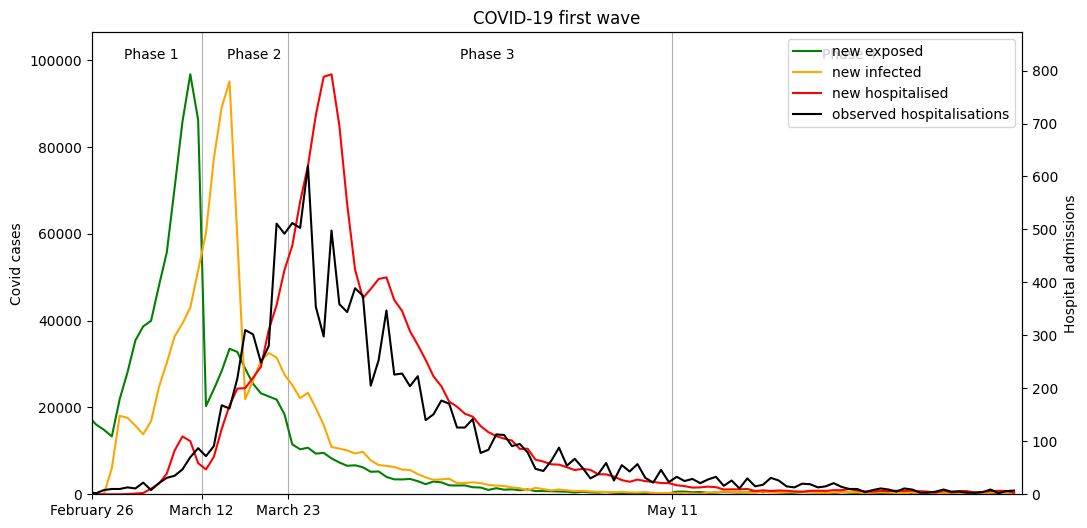

In [171]:
import matplotlib.pyplot as plt

# Recreates figure 2(a) of the paper
avg_ref_data = [data for data in avg_data_points if data.name=='ref'][0]

fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()

plt.title('COVID-19 first wave')
plt.xlabel('time (h)')

ax1.set_ylabel('Covid cases')
ax2.set_ylabel('Hospital admissions')

#Get starts of phases
phase2 = np.argmax(avg_ref_data.phases[0]==2)
phase3 = np.argmax(avg_ref_data.phases[0]==3)
phase4 = np.argmax(avg_ref_data.phases[0]==4) # might be 0 if model ran for too little days, dont include in 'phases' list in that case
phase1 = phase2 - 14 * 24 # feb 27th is 14 days before march 12th

phases = [phase1, phase2, phase3, phase4]

x_max = timesteps
plt.xlim(phase1, x_max)
y1_max = np.max(avg_ref_data.new_exposed)
y2_max = np.max(avg_ref_data.hospital)
ax1.set_ylim([0, y1_max * 1.1])
ax2.set_ylim([0, y2_max * 1.1])

lines = []
time_range_daily = np.arange(0, x_max, 24)
ln1 = ax1.plot(time_range_daily, avg_ref_data.new_exposed, label='new exposed', color='green')
ln2 = ax1.plot(time_range_daily, avg_ref_data.new_infected, label='new infected', color='orange')
ln3 = ax2.plot(time_range_daily, avg_ref_data.hospital, label='new hospitalised', color='red')
ln4 = ax2.plot(time_range_daily, daily_addmisions[:120], label='observed hospitalisations', color='black')
lines = lines + ln1 + ln2 + ln3 + ln4

# Print phase labels on top of graph
phase_labels = ['Phase 1', 'Phase 2', 'Phase 3', 'Phase 4']
phase_label_pos = np.array([phase2 /2, (phase3+phase2) / 2, (phase4+phase3) / 2, (x_max+phase4) / 2]) / x_max
for label, pos in zip(phase_labels, phase_label_pos):
    ax1.text(pos, 0.95, label, transform=ax1.transAxes,
         ha='center', va='center', fontsize=10)

# Compute phase date
march12 = pd.to_datetime('2022-03-12')
date_p1 = march12 + pd.DateOffset(hours= -int(phase2-phase1))
date_p3 = march12 + pd.DateOffset(hours=  int(phase3-phase2))
date_p4 = march12 + pd.DateOffset(hours=  int(phase4-phase2))

# Print specific date labels on x-axis
ax1.grid(axis='x')
ax1.set_xticks(phases, map(lambda dt: dt.strftime('%B %d'), [date_p1, march12, date_p3, date_p4]))
ax1.legend(lines, [l.get_label() for l in lines])
plt.show()

371.0
390.0
383.0
387.0
373.0


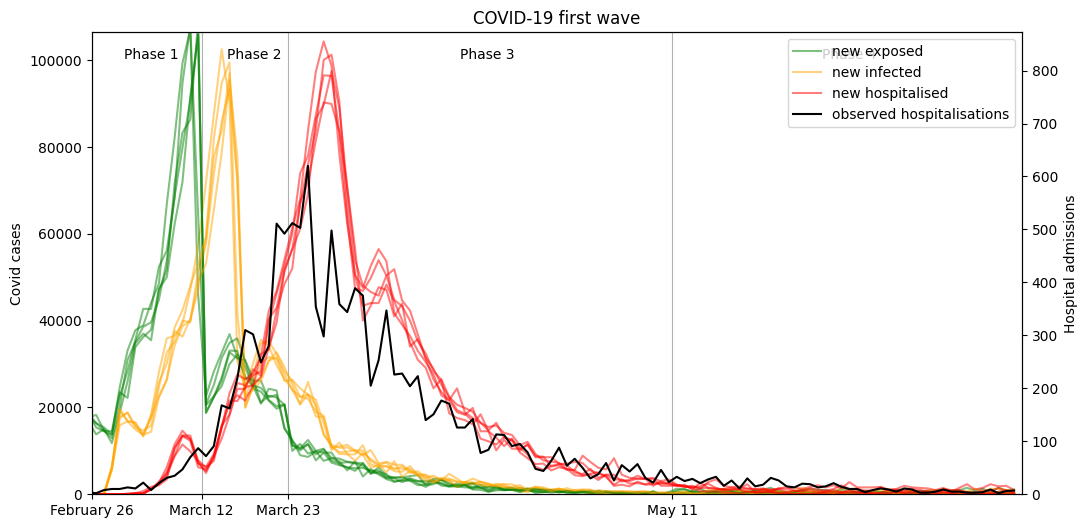

In [172]:
import matplotlib.pyplot as plt

# Recreates figure 2(a) of the paper
avg_ref_data = [data for data in avg_data_points if data.name=='ref'][0]

fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()

plt.title('COVID-19 first wave')
plt.xlabel('time (h)')

ax1.set_ylabel('Covid cases')
ax2.set_ylabel('Hospital admissions')

#Get starts of phases
phase2 = np.argmax(avg_ref_data.phases[0]==2)
phase3 = np.argmax(avg_ref_data.phases[0]==3)
phase4 = np.argmax(avg_ref_data.phases[0]==4) # might be 0 if model ran for too little days, dont include in 'phases' list in that case
phase1 = phase2 - 14 * 24 # feb 27th is 14 days before march 12th

phases = [phase1, phase2, phase3, phase4]

x_max = timesteps
plt.xlim(phase1, x_max)
y1_max = np.max(avg_ref_data.new_exposed)
y2_max = np.max(avg_ref_data.hospital)
ax1.set_ylim([0, y1_max * 1.1])
ax2.set_ylim([0, y2_max * 1.1])

lines = []
time_range_daily = np.arange(0, x_max, 24)
for run in [data for data in data_points if data.name=='ref']:
    print(run.timestep)
    ln1 = ax1.plot(time_range_daily, np.sum(run.new_exposed.reshape(-1,24),axis=1), label='new exposed', color='green', alpha=0.5)
    ln2 = ax1.plot(time_range_daily, np.sum(run.new_infected.reshape(-1,24),axis=1), label='new infected', color='orange', alpha=0.5)
    ln3 = ax2.plot(time_range_daily, np.sum(run.hospital.reshape(-1,24),axis=1), label='new hospitalised', color='red', alpha=0.5)
    lines = ln1 + ln2 + ln3
ln4 = ax2.plot(time_range_daily, daily_addmisions[:120], label='observed hospitalisations', color='black')
lines = lines + ln4

# Print phase labels on top of graph
phase_labels = ['Phase 1', 'Phase 2', 'Phase 3', 'Phase 4']
phase_label_pos = np.array([phase2 /2, (phase3+phase2) / 2, (phase4+phase3) / 2, (x_max+phase4) / 2]) / x_max
for label, pos in zip(phase_labels, phase_label_pos):
    ax1.text(pos, 0.95, label, transform=ax1.transAxes,
         ha='center', va='center', fontsize=10)

# Compute phase date
march12 = pd.to_datetime('2022-03-12')
date_p1 = march12 + pd.DateOffset(hours= -int(phase2-phase1))
date_p3 = march12 + pd.DateOffset(hours=  int(phase3-phase2))
date_p4 = march12 + pd.DateOffset(hours=  int(phase4-phase2))

# Print specific date labels on x-axis
ax1.grid(axis='x')
ax1.set_xticks(phases, map(lambda dt: dt.strftime('%B %d'), [date_p1, march12, date_p3, date_p4]))
ax1.legend(lines, [l.get_label() for l in lines])
plt.show()

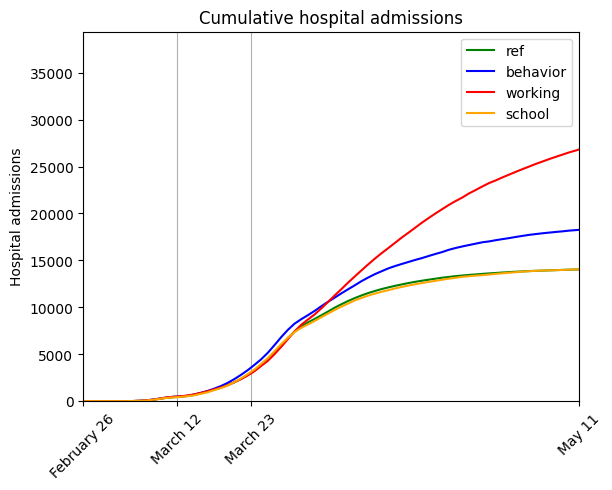

In [173]:
# Recreates figure 3(a) of the paper

# For easy comparison to figure 3 of the paper.
color_map = {
    'ref': 'green',
    'school': 'orange',
    'behavior': 'blue',
    'working': 'red'
}

plt.title('Cumulative hospital admissions')

plt.ylabel('Hospital admissions')


y_max_total = 0
for data in avg_data_points:
    plt.plot(time_range_daily, np.cumsum(data.hospital), label=data.name, color=color_map[data.name])
    y_max = np.sum(data.hospital)
    if y_max_total < y_max:
        y_max_total = y_max

x_max = len(data.hospital)
plt.xlim(phase1, x_max)
plt.ylim([0, y_max_total * 1.1])

plt.grid(axis='x')
plt.xticks([phase1, phase2, phase3, phase4],
           labels= map(lambda dt: dt.strftime('%B %d'), [date_p1, march12, date_p3, date_p4]), 
           rotation=45)

plt.legend()
plt.show()